If you missed it, take a quick glance at the previous notebook "1 - Data Browser" since it will give you an overview of the datasets we'll use in this notebook.

## Auto Encoders

At it's core, an autoencoder is a function that takes complex inputs and performs a dimensionality reduction of the data.  Principal Component Analysis is an example of a classical encoding algorithm.  Even a simple linear regression in 2D can serve as an encoder, since you map 2 dimensions (x and y) into just one dimension (position along a line).

An important feature of autoencoders is the ability to reconstruct the input data from the compressed feature representation.  It's easy to see how this is done when you have used PCA or linear regression, but it is more complex with a neural network.

One advantage of using neural networks as auto-encoders is that they have capacity to encode complex data, and the training regime for encoding is not overly complex and similar for many types of data.

In this notebook, we will build an autoencoder for handwritten digits between 0 and 99, inclusive, generated via the mnist dataset.

In [1]:
# Load the data generator and tensorflow:

import tensorflow as tf
import numpy
tf.enable_eager_execution()
from src.utils import data_generator

### Part 1: Build our models

We'll build two autoencoder models, one with a classic neural network and one with a convolutional neural network.  We'll map both down to the same intermediate representation.

Our decoder stages will be built on the same core operations as the encoders but in reverse.

#### Feed Forward NN encoder (no convolutions)

In [2]:
from src.models import neural_net_AE

# Core training parameters:
N_TRAINING_ITERATION = 5000
BATCH_SIZE = 64
NUM_DIGITS = 1

In [3]:
# Let's set up our models:

encoder = neural_net_AE.Encoder()
decoder = neural_net_AE.Decoder(NUM_DIGITS)




Because we are using eager execution, we can not view the models until we run through them at least once.  So let's set up the data generator and then we can see the layers of the network clearly:

In [4]:
data_gen = data_generator.mnist_generator()

# Load some data:
batch_images, batch_labels = data_gen.next_train_batch(BATCH_SIZE, NUM_DIGITS)
# Reshape the data:
batch_images = batch_images.reshape([BATCH_SIZE, 28*28*NUM_DIGITS])

intermediate_state = encoder(batch_images)
decoded_images = decoder(intermediate_state)


In [5]:
print("Here is the encoder model:")
encoder.summary()
print("Here is the intermediate representation shape:")
print(intermediate_state.shape)
print("Here is the decoder model: ")
decoder.summary()
print("Here is the decoded images shape:")
print(decoded_images.shape)

Here is the encoder model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  615440    
_________________________________________________________________
dense_1 (Dense)              multiple                  307720    
_________________________________________________________________
dense_2 (Dense)              multiple                  38514     
_________________________________________________________________
dense_3 (Dense)              multiple                  990       
Total params: 962,664
Trainable params: 962,664
Non-trainable params: 0
_________________________________________________________________
Here is the intermediate representation shape:
(64, 10)
Here is the decoder model: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)          

In [6]:
# For an optimizer, we will use Adam Optimizer:

optimizer = tf.train.AdamOptimizer()


Training the network proceeds in a few iterative steps:
 - Load a batch of data
 - Feed the data into the network, compute the loss, back prop the gradients (which is all handled automatically by tensorflow)


In [7]:
data_gen = data_generator.mnist_generator()

loss_history = []
val_loss_history = []
val_steps = []

for i in range(N_TRAINING_ITERATION):

    # Load some data:
    batch_images, batch_labels = data_gen.next_train_batch(BATCH_SIZE, NUM_DIGITS)
    # Reshape the data:
    batch_images = batch_images.reshape([BATCH_SIZE, 28*28*NUM_DIGITS])
    with tf.GradientTape() as tape:
        intermediate_state = encoder(batch_images)
        decoded_images = decoder(intermediate_state)
        loss_value = tf.losses.mean_squared_error(batch_images, decoded_images)

    if i % 50 == 0:
        test_images, test_labels = data_gen.next_test_batch(BATCH_SIZE, NUM_DIGITS)
        test_images = test_images.reshape([BATCH_SIZE, 28*28*NUM_DIGITS])
        val_intermediate_state = encoder(test_images)
        val_decoded_images = decoder(intermediate_state)
        val_loss_value = tf.losses.mean_squared_error(batch_images, decoded_images)
        val_loss_history.append(val_loss_value.numpy())
        val_steps.append(i)


        
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables


    loss_history.append(loss_value.numpy())

    # Apply the update to the model:
    grads = tape.gradient(loss_value, trainable_vars)
    optimizer.apply_gradients(zip(grads, trainable_vars),
                             global_step=tf.train.get_or_create_global_step())

    if i % 50 == 0:
        print("Step {}, loss {}".format(i, loss_history[-1]))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Step 0, loss 0.1115257665514946
Step 50, loss 0.048358406871557236
Step 100, loss 0.034473877400159836
Step 150, loss 0.03216897323727608
Step 200, loss 0.0297272689640522
Step 250, loss 0.02496604062616825
Step 300, loss 0.026393720880150795
Step 350, loss 0.025455020368099213
Step 400, loss 0.025202356278896332
Step 450, loss 0.025531258434057236
Step 500, loss 0.02316392958164215
Step 550, loss 0.023719055578112602
Step 600, loss 0.02387535572052002
Step 650, loss 0.02214168943464756
Step 700, loss 0.023450693115592003
Step 750, loss 0.022542674094438553
Step 800, loss 0.0213906429708004
Step 850, loss 0.020155325531959534
Step 900, loss 0.019893623888492584
Step 950, loss 0.022612152621150017
Step 1000, loss 0.01995300129055977
Step 1050, loss 0.021668842062354088
Step 1100, loss 0.01960560493171215
Step 1150, loss 0.019181137904524803
Step 1200, loss 0.0189998261

On my laptop, 5000 iterations took 2 or 3 minutues to train (on the CPU).  So you should get to good results without too much delay.  Let's plot the loss to see how training progressed:

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline 

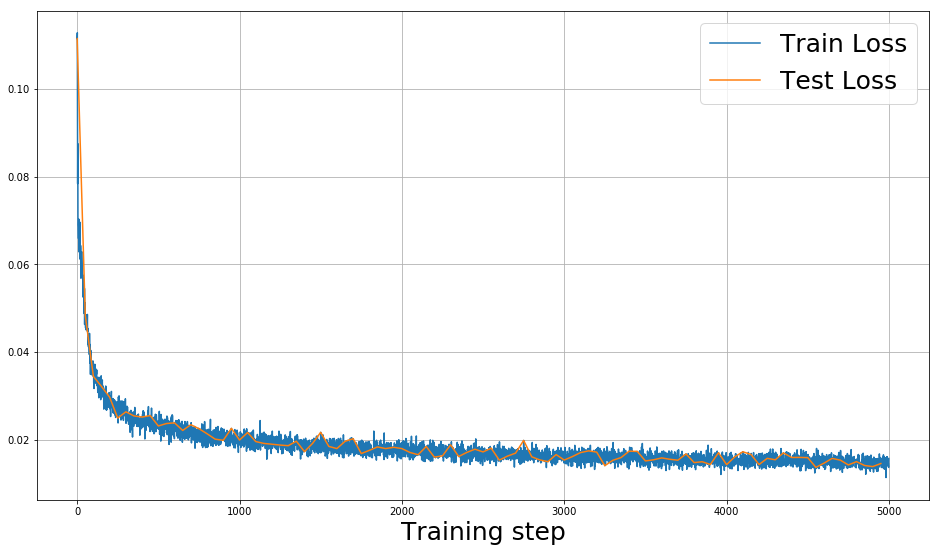

In [9]:
fig = plt.figure(figsize=(16,9))
plt.plot(range(len(loss_history)), loss_history, label="Train Loss")
plt.plot(val_steps, val_loss_history, label="Test Loss")
plt.grid(True)
plt.legend(fontsize=25)
plt.xlabel("Training step", fontsize=25)
plt.show()

This is reasonable behavior for a loss function, the loss decreases rapidly at first and then slows.  Since we didn't evaluate on the test set, it's impossible to know if this model was overtrained or not just from this plot.  But there are other ways to check.

Next let's compare the original images, intermediate representations, and output images.  We can evaluate this for both the input and the test set.

In [10]:
def run_inference(_encoder, _decoder, input_images):

    N_INFERENCE_IMAGES = input_images.shape[0]
    input_images = input_images.reshape(N_INFERENCE_IMAGES, 
                                        NUM_DIGITS*28*28)


    intermediate_rep = _encoder(input_images)
    decoded_images = _decoder(intermediate_rep)
    decoded_images = decoded_images.numpy().reshape(
        N_INFERENCE_IMAGES*28, NUM_DIGITS*28)
    
    return intermediate_rep, decoded_images

In [11]:
N_INFERENCE_IMAGES = 2


original_images, labels = data_gen.next_train_batch(
    N_INFERENCE_IMAGES, NUM_DIGITS)

intermediate_rep, decoded_images = run_inference(
    encoder, decoder, original_images)
original_images = original_images.reshape(N_INFERENCE_IMAGES*28, NUM_DIGITS*28)

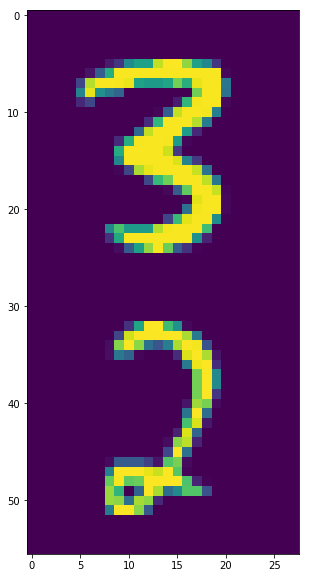

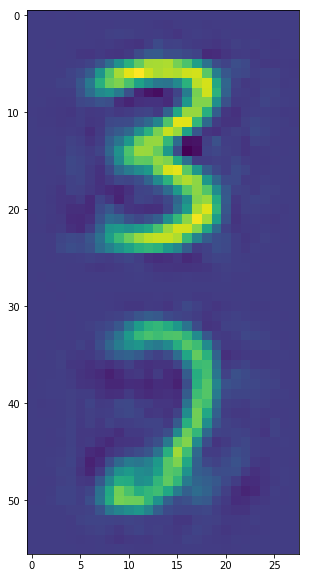

In [12]:
fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(original_images)
plt.show()
fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(decoded_images)
plt.show()

Well, this is interesting!  The outputs of the autoencoder definitely look like numbers, though not *exactly* the numbers that went into the network.  What does the intermediate representation look like?

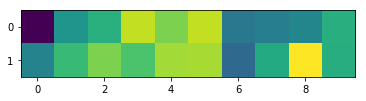

In [13]:
plt.imshow(intermediate_rep)
plt.show()

Can you tell what the numbers are from the intermediate representation?  I certainly can't.  But the decoder can, to a large extent, and that is impressive!

Below, we use the autoencoder on the test dataset, which it has never seen before, to see how well the model generalizes:

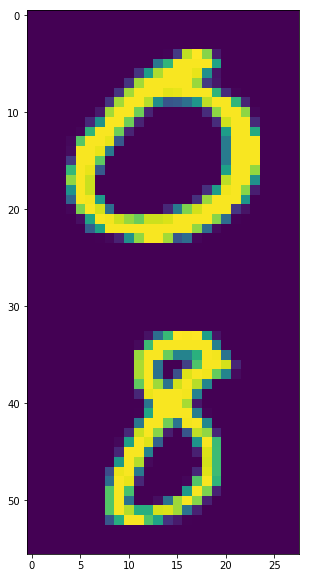

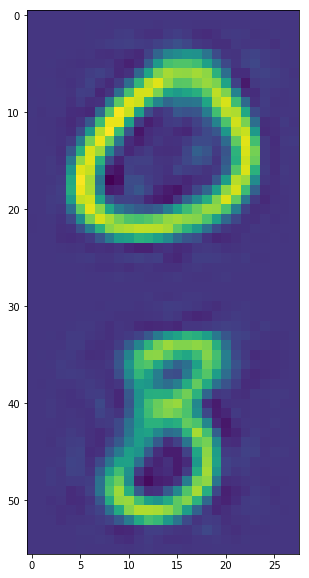

In [14]:
N_INFERENCE_IMAGES = 2


original_images, labels = data_gen.next_test_batch(
    N_INFERENCE_IMAGES, NUM_DIGITS)

intermediate_rep, decoded_images = run_inference(
    encoder, decoder, original_images)
original_images = original_images.reshape(N_INFERENCE_IMAGES*28, NUM_DIGITS*28)

fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(original_images)
plt.show()
fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(decoded_images)
plt.show()

### Save your models

As a last step in this notebook, let's save the trained encoders and decoders.  We will use them later to compare different methods:

In [15]:
encoder.save_weights("saved_models/user/nn_encoder.h5")
decoder.save_weights("saved_models/user/nn_decoder.h5")

Let's move on to the 3rd notebook in this tutorial, convolutional autoencoders.